### Problem Statement

Build a model of housing prices in California using the California census data. This data has metrics such as the population, median income, median housing price, and so on for each block group in California. Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). We will just call them "districts" for short.

Our model should learn from this data and be able to predict the median housing price in any district, given all the other metrics.

Specifically, this is a *multivariate regression* problem since the system will use multiple features to make a prediction (it will use the district’s population, the median income, etc.).

### Get the Data

In [151]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline

In [152]:
# The info() method is useful to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null value
housing = pd.read_csv('datasets/housing/housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [153]:
# The info() method is useful to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20,640 instances in the dataset, which means that it is fairly small by Machine Learning standards, but it's perfect to get started. Notice that the *total_bedrooms* attribute has only 20,433 non-null values, meaning that 207 districts are missing this feature. We will need to take care of this later. All attributes are numerical, except the ocean_proximity field.

When we looked at the top five rows, we can notice that the values in that column are repetitive, which means that it is probably a categorical attribute. You can find out what categories exist and how many districts belong to each category by using the value_counts()

In [154]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Let's look at the other fields. The describe() method shows a summary of the numerical attributes

### Quick Glance on the Data

In [155]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


The *count*, *mean*, *min*, and *max* rows are self-explanatory. Note that the null values are ignored (so, for example, *count* of *total_bedrooms* is 20,433, not 20,640). The std row shows the standard deviation (which measures how dispersed the values are). The 25%, 50%, and 75% rows show the corresponding *percentiles*: a percentile indicates the value below which a given percentage of observations in a group of observations falls. For example, 25% of the districts have a *housing_median_age* lower than 18, while 50% are lower than 29 and 75% are lower than 37. These are often called the 25<sup>th</sup> percentile (or 1<sup>st</sup> quartile), the median, and the 75<sup>th</sup> percentile (or 3<sup>rd</sup> quartile).

Another quick way to get a feel of the type of data we are dealing with is to plot a histogram for each numerical attribute. A histogram shows the number of instances (on the vertical axis) that have a given value range (on the horizontal axis). We can either plot this one attribute at a time, or you can call the *hist()* method on the whole dataset, and it will plot a histogram for each numerical attribute. For example, we can see that slightly over 1000 districts have a median_house_value equal to about $500,000.

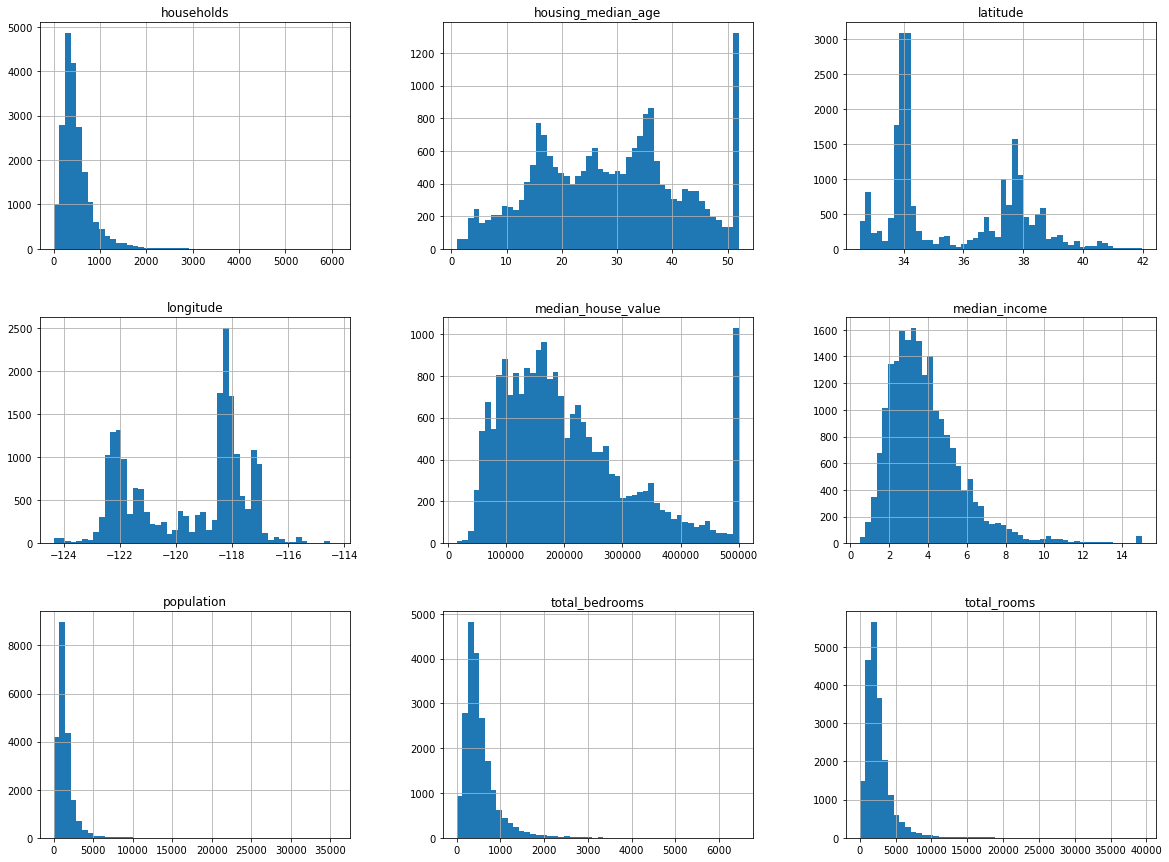

In [156]:
housing.hist(bins=50, figsize=(20, 15));

For example, we can see that slightly over 1000 districts have a *median_house_value* equal to about $500,000.

Notice a few things in these histograms: 

1. First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, we are told that the data has been scaled and capped at 15 (actually 15.0001) for higher median incomes, and at 0.5 (actually 0.4999) for lower median incomes. Working with preprocessed attributes is common in Machine Learning, and it is not necessarily a problem, but we should try to understand how the data was computed.

2. The housing median age and the median house value were also capped. The latter may be a serious problem since it is our target attribute (our labels). Our Machine Learning algorithms may learn that prices never go beyond that limit. We need to check with our client team (the team that will use our system's output) to see if this is a problem or not. If they tell us that they need precise predictions even beyond $500,000, then we have mainly two options:

    - a. Collect proper labels for the districts whose labels were capped.
    
    - b. Remove those districts from the training set (and also from the test set, since our system should not be evaluated poorly if it predicts values beyond $500,000). 
    
3. These attributes have very different scales. We will discuss this later when we explore feature scaling. 

4. Finally, many histograms are tail heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

In [157]:
# to make this notebook's output identical at every run
np.random.seed(42)

### Create a Test Set

It may sound strange to voluntarily set aside part of the data at this stage. After all, we have only taken a quick glance at the data, and surely we should learn a whole lot more about it before we decide what algorithms to use, right? This is true, but our brain is an amazing pattern detection system, which means that it is highly prone to overfitting: if we look at the test set, we may stumble upon some seemingly interesting pattern in the test data that leads us to select a particular kind of Machine Learning model. When we estimate the generalization error using the test set, our estimate will be too optimistic and we will launch a system that will not perform as well as expected. This is called *data snooping* bias. Creating a test set is theoretically quite simple: just pick some instances randomly, typically 20% of the dataset, and set them aside:

In [158]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [159]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


So far we have considered purely random sampling methods. This is generally fine if our dataset is large enough (especially relative to the number of attributes), but if it is not, we run the risk of introducing a significant sampling bias. When a survey company decides to call 1,000 people to ask them a few questions, they don't just pick 1,000 people randomly in a phone booth. They try to ensure that these 1,000 people are representative of the whole population. For example, the US population is composed of 51.3% female and 48.7% male, so a well-conducted survey in the US would try to maintain this ratio in the sample: 513 female and 487 male. This is called *stratified sampling*: the population is divided into homogeneous subgroups called *strata*, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population. If they used purely random sampling, there would be about 12% chance of sampling a skewed test set with either less than 49% female or more than 54% female. Either way, the survey results would be significantly biased. Suppose we chatted with experts who told us that the median income is a very important attribute to predict median housing prices. We may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, we first need to create an income category attribute. Let's look at the median income histogram more closely.

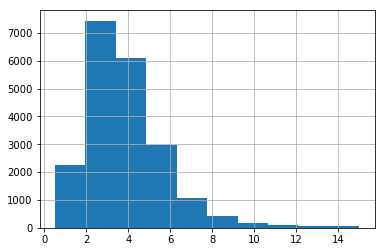

In [160]:
housing['median_income'].hist()

Most median income values are clustered around 2– 5 (tens of thousands of dollars), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in our dataset for each stratum, or else the estimate of the stratum’s importance may be biased. This means that we should not have too many strata, and each stratum should be large enough. The following code creates an income category attribute by dividing the median income by 1.5 (to limit the number of income categories), and rounding up using *ceil* (to have discrete categories), and then merging all the categories greater than 5 into category 5:

In [161]:
housing['median_income'].max()

15.0001

In [162]:
# Divide by 1.5 to limit the number of income categories
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)

In [163]:
housing['income_cat'].sample(5)

20046    2.0
3024     2.0
15663    3.0
20484    4.0
9814     3.0
Name: income_cat, dtype: float64

In [164]:
# Label those above 5 as 5
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

In [165]:
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

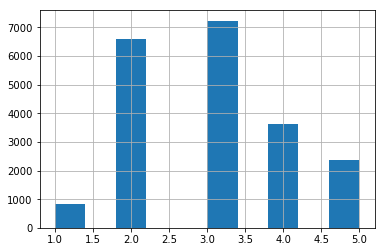

In [166]:
housing["income_cat"].hist()

Now we are ready to do stratified sampling based on the income category. For this we can use Scikit-Learn's train_test_split with stratify parameter.

In [167]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify = housing['income_cat'], random_state=42)

Let's see if this worked as expected. We can start by looking at the income category proportions in the full housing dataset:

In [168]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

With similar code you can measure the income category proportions in the test set.

In [169]:
def income_cat_proportions(data):
    return data.value_counts() / len(data)

In [170]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [171]:
compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing['income_cat']),
    "Stratified" : income_cat_proportions(strat_test_set['income_cat']),
    "Random" : income_cat_proportions(test_set['income_cat'])
})

compare_props.sort_index(inplace=True)

compare_props['Rand. %error'] = 100 * compare_props['Random'] / compare_props['Overall'] - 100
compare_props['Strat. %error'] = 100 * compare_props['Stratified'] / compare_props['Overall'] - 100

In [172]:
compare_props

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011


Form the table compares the income category proportions in the overall dataset, in the test set generated with stratified sampling, and in a test set generated using purely random sampling. As we can see, the test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, whereas the test set generated using purely random sampling is quite skewed.

Now we should remove the income_cat attribute so the data is back to its original state:

In [173]:
strat_test_set.drop("income_cat", axis=1, inplace=True)

D:\Work\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Discover and Visualize the Data to Gain Insights

So far we have only taken a quick glance at the data to get a general understanding of the kind of data we are manipulating. Now the goal is to go a little bit more in depth. First, make sure we have put the test set aside and we are only exploring the training set. Also, if the training set is very large, we may want to sample an exploration set, to make manipulations easy and fast. In our case, the set is quite small so we can just work directly on the full set. Let's create a copy so we can play with it without harming the training set:

In [174]:
housing = strat_train_set.copy()

### Visualizing Geographical Data 

Since there is geographical information (latitude and longitude), it is a good idea to create a scatterplot of all districts to visualize the data

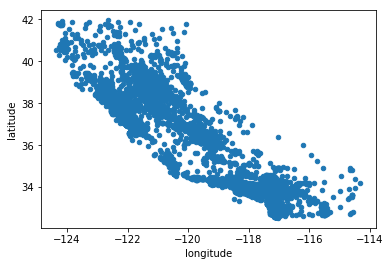

In [175]:
housing.plot(kind='scatter', x='longitude', y='latitude')

This looks like California all right, but other than that it is hard to see any particular pattern. Setting the alpha option to 0.1 makes it much easier to visualize the places where there is a high density of data points.

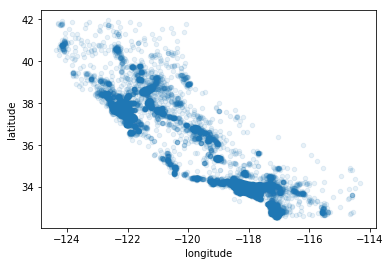

In [176]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

Now that's much better: you can clearly see the high-density areas, namely the Bay Area and around Los Angeles and San Diego, plus a long line of fairly high density in the Central Valley, in particular around Sacramento and Fresno. More generally, our brains are very good at spotting patterns on pictures, but we may need to play around with visualization parameters to make the patterns stand out. Now let's look at the housing prices. The radius of each circle represents the district's population (option s), and the color represents the price (option c). We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices):

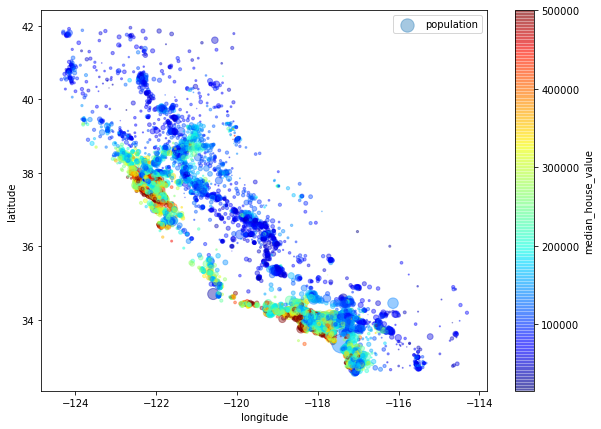

In [179]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend();

This image tells us that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density, as we probably knew already. It will probably be useful to use a clustering algorithm to detect the main clusters, and add new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.

Looking for Correlations Since the dataset is not too large, you can easily compute the standard correlation coefficient (also called Pearson's r) between every pair of attributes using the *corr()* method: